TD n°1 : Introduction to PyTorch

S. Delprat, INSA Hauts-de-France    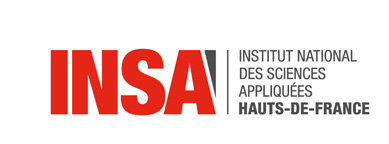


The main objectives of this exercise session is to understand how to use pytorch tensors to perform a basic 1D curve  fitting.

In [26]:
import torch
import pandas as pd
# import gdown
import matplotlib.pyplot as plt

# I) Import & visualize data

**Q1.** Retrieve data

1.   Copy the file "dataTD1.csv" on your Google Drive
2.   Share that file using a link and note the link URL
3.   Use gdown to copy the file into the current Colab machine



**Q2.** Use panda to download the csv

In [27]:
df = pd.read_csv('../data/raw/dataTD1.csv')
df.head(10)

,x,y
0,0.155979,-37.178381
1,7.133130,131.170169
2,-2.313728,104.336277
3,3.913819,97.426606
4,2.558084,-143.761992
5,-0.992237,84.310260
6,-0.527641,39.972846
7,8.994127,331.946154
8,-8.330049,-459.754159
9,-4.403422,3.603814


**Q3.** Use the describe method of the dataframe to display information about the data

In [28]:
df.describe()

,x,y
count,300.000000,300.000000
mean,0.277910,-27.653652
std,5.769276,246.521342
min,-9.913299,-878.033396
25%,-4.480942,-68.372027
50%,0.122460,23.915739
75%,5.459625,95.380362
max,9.824064,464.147759


**Q4.** Convert data from the dataframe to float 32 tensors



In [29]:
X = torch.tensor(df['x'].values, dtype=torch.float32)
y = torch.tensor(df['y'].values, dtype=torch.float32)

**Q5.** Visualize the data using matplotlib

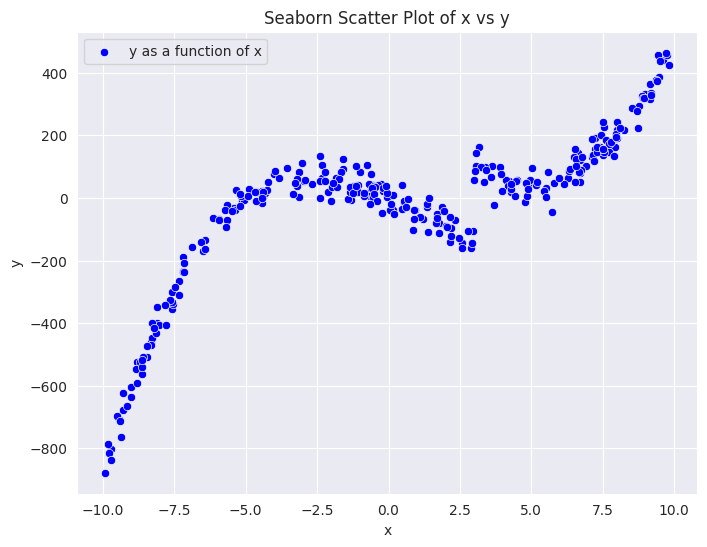

In [30]:
import seaborn as sns

# Seaborn Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X, y=y, color='blue', label='y as a function of x')
plt.title('Seaborn Scatter Plot of x vs y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# 2) dataset & data loader creation

## 2.1) datasets creation

**Q6.** Write a custom dataset class to produce data sample $(x_i,y_i)$

In [31]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, input_data, labels):
        self.x = input_data
        self.y = labels
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

**Q7.** Create a dataset object for the whole data set

In [32]:
dataset = MyDataset(X, y)

**Q8.** Split data into test, validation and train using torch.utils.data.random_split

In [33]:
from torch.utils.data import random_split
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

**Q9.** Display the data of every indivudual dataset

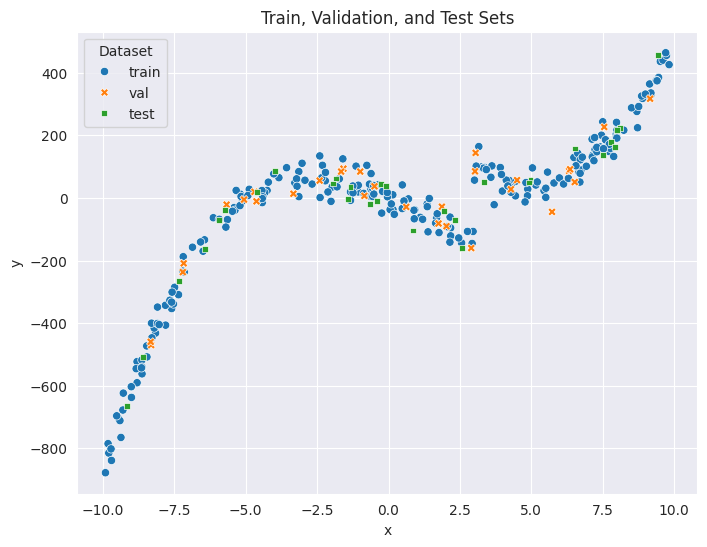

In [34]:
# Function to extract data from the dataset split
def extract_data(dataset_split):
    x_values, y_values = [], []
    for x, y in dataset_split:
        x_values.append(x.item())
        y_values.append(y.item())
    return x_values, y_values

# Extract data from each split
train_x, train_y = extract_data(train_set)
val_x, val_y = extract_data(val_set)
test_x, test_y = extract_data(test_set)


# Combine the data into a DataFrame for easier plotting
data = {
    'x': train_x + val_x + test_x,
    'y': train_y + val_y + test_y,
    'set': (['train'] * len(train_x)) + (['val'] * len(val_x)) + (['test'] * len(test_x))
}
df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='x', y='y', hue='set', style='set')
plt.title('Train, Validation, and Test Sets')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

## 2.2) Data loaders creation

**Q10.** Create a data loader for each sub-dataset

In [35]:
batchSize=32

In [36]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=batchSize, shuffle=True)
val_loader = DataLoader(dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

# 3) Model

**Q11.** Let us first design a very simple model consisting in a single hidden layer followed by ReLu.
In the __init__ method define and store the layers and in the __forward__ method compute the model output given its input

In [37]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyModel, self).__init__()
        # Define the layers with appropriate dimensions
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.hidden_layer(self.relu(self.input_layer(x)))

In [38]:
model = MyModel(input_size=1, hidden_size=10, output_size=1)

# 3) Train the model

In order to train the model, you need to write some code to:


1.   Iterate over a given number of epoch
2.   Iterate over the available batch within one epoch
3.   Optimize the model by computing gradients over one batch and taking a step
4.   At every epoch, compute the model performance over the validation data
5.   Store model performance (training & validation)
6.   Display training curves : training & validation metrics
7.   Finally display predicted curve vs test data (as well as metric over test data)




**Q12.** Define all the needed variables (max number of epochs, learning rate, etc.) and initialize arrays to solve model loss over training & validation dataset


In [39]:
n_epochs = 1000
learning_rate = 1e-3

**Q13.** Define a relevant loss function

In [40]:
mse_loss = nn.MSELoss()

**Q14.** Define an optimizer (Adam)

In [41]:
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Q15.** Program the main training loops

A few tips:


*   As the dataset provide scalar values, the dataloader is outputing batches with only one dimension. Use "unsqueeze_" to make sure that the batch have (batchSize,1) dimension
*   Although this may not be necessary here, it is a good practice to use model.eval() before the validation computation and put it on model.train() at the end of the validation computation
*   As the validation computation is not used to compute any gradient, use   with torch.no_grad():




In [42]:
from tqdm import tqdm

# Define the train function
def train(epoch):
    model.train()  # Set the model to training mode
    train_losses = []  # Initialize an empty list to store training losses

    # Training loop
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch} [Training]"):
        opt.zero_grad()  # Zero the gradients from the previous step
        
        # Forward pass
        predictions = model(X.unsqueeze(1))
        loss = mse_loss(predictions, y.unsqueeze(1))  # Calculate the loss
        
        # Backward pass
        loss.backward()  # Compute gradients
        opt.step()  # Update model parameters
        
        # Record the training loss
        train_losses.append(loss.item())
    
    # Log the average training loss for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    
    return avg_train_loss


# Define the validation function
def validate():
    model.eval()  # Set the model to evaluation mode
    val_losses = []  # Initialize an empty list to store validation losses

    with torch.no_grad():  # Disable gradient calculation for validation
        for X, y in val_loader:
            predictions = model(X.unsqueeze(1))
            loss = mse_loss(predictions, y.unsqueeze(1))
            val_losses.append(loss.item())
    
    avg_val_loss = sum(val_losses) / len(val_losses)
    return avg_val_loss


# Define the combined training and validation loop
def train_with_validation(n_epochs):
    train_losses, val_losses = [], []  # Lists to store losses across epochs

    for epoch in range(1, n_epochs + 1):
        train_loss = train(epoch)  # Perform training for the epoch
        val_loss = validate()  # Perform validation for the epoch
        
        # Append losses for tracking
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [43]:
train_losses, val_losses = train_with_validation(n_epochs=n_epochs)

Epoch 1000 [Training]: 100%|██████████| 10/10 [00:00<00:00, 684.66it/s]


**Q16.** Display training curves

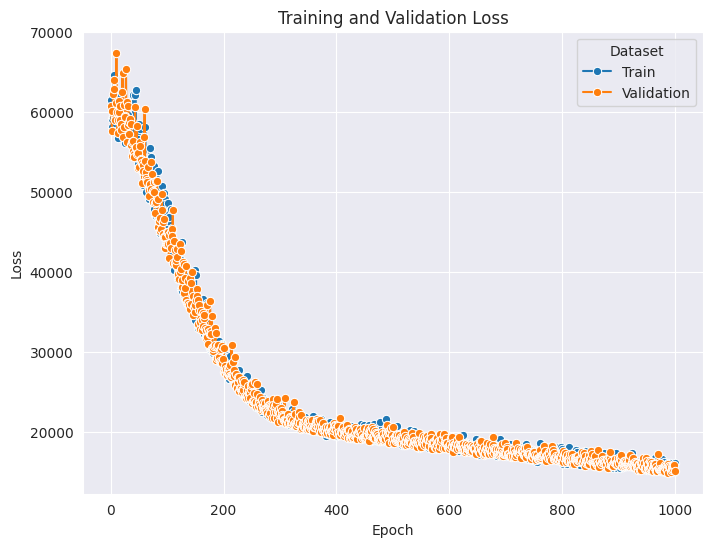

In [44]:
epochs = list(range(1, len(train_losses) + 1))  # Epoch numbers

# Prepare data for plotting
data = pd.DataFrame({
    'Epoch': epochs + epochs,  # Duplicate epoch numbers for train and val
    'Loss': train_losses + val_losses,
    'Set': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)  # Labels
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=data, x='Epoch', y='Loss', hue='Set', marker='o')

# Customize the plot
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Dataset')
plt.grid(True)
plt.show()

**Q17.** Compute the loss over the test dataset

In [45]:
# Define the validation function
def test():
    model.eval()  # Set the model to evaluation mode
    test_losses = []  # Initialize an empty list to store validation losses

    with torch.no_grad():  # Disable gradient calculation for validation
        for X, y in test_loader:
            predictions = model(X.unsqueeze(1))
            loss = mse_loss(predictions, y.unsqueeze(1))
            test_losses.append(loss.item())
            
    return sum(test_losses) / len(test_losses)

In [46]:
test()

15443.49755859375

**Q18.** Compute the model curve over the min & max value contained in the whole dataset (X loaded in Q4)

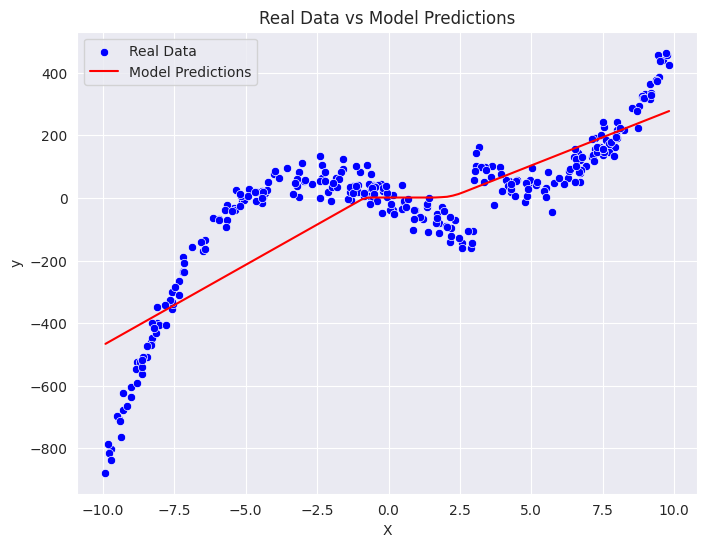

In [47]:
# Find the range of X
X_min, X_max = X.min().item(), X.max().item()

# Generate a range of X values for predictions
X_pred = torch.linspace(X_min, X_max, 100).reshape(-1, 1)  # Smooth X values

# Predict using the trained model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No gradient calculation needed
    y_hat = model(X_pred).squeeze()  # Get model predictions

# Plot the real data and model predictions
plt.figure(figsize=(8, 6))

# Scatter plot for real data
sns.scatterplot(x=X, y=y, color='blue', label='Real Data')

# Line plot for model predictions
sns.lineplot(x=X_pred.squeeze(), y=y_hat, color='red', label='Model Predictions')

# Customize the plot
plt.title('Real Data vs Model Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

**Q19.** It may be difficult to caputre the discontinuity occuring at x=2.5. Modify the model such that the discontinuity is captured

In [48]:
from torch import nn

class DiscontinuityModel(nn.Module):
    def __init__(self):
        super(DiscontinuityModel, self).__init__()
        # Define a deeper neural network
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # First layer
            nn.ReLU(),         # Activation
            nn.Linear(64, 128),  # Second layer
            nn.ReLU(),
            nn.Linear(128, 64),  # Third layer
            nn.ReLU(),
            nn.Linear(64, 1)    # Output layer
        )
        
    def forward(self, x):
        return self.net(x)

Epoch 1/1000: Train Loss = 58416.2678, Val Loss = 61360.0033
Epoch 100/1000: Train Loss = 3007.0680, Val Loss = 3263.4569
Epoch 200/1000: Train Loss = 2095.4728, Val Loss = 1992.9678
Epoch 300/1000: Train Loss = 1885.3061, Val Loss = 1837.6715
Epoch 400/1000: Train Loss = 1790.3477, Val Loss = 1749.1707
Epoch 500/1000: Train Loss = 1923.4510, Val Loss = 1726.6748
Epoch 600/1000: Train Loss = 2017.0614, Val Loss = 2070.1498
Epoch 700/1000: Train Loss = 1647.2889, Val Loss = 1603.9872
Epoch 800/1000: Train Loss = 1658.0826, Val Loss = 1466.9265
Epoch 900/1000: Train Loss = 1576.0198, Val Loss = 1458.2006
Epoch 1000/1000: Train Loss = 1387.4581, Val Loss = 1287.7672


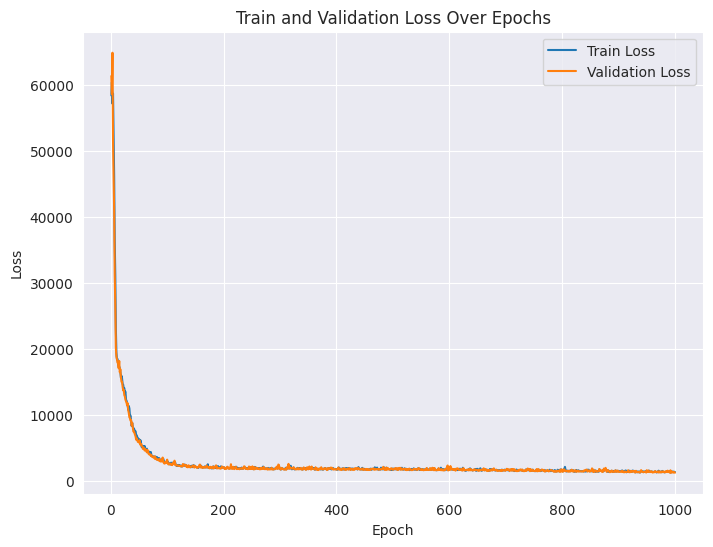

In [49]:
# Define the model, loss function, and optimizer
model2 = DiscontinuityModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

# Training loop
epochs = 1000
train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training phase
    model2.train()
    epoch_train_loss = 0  # Accumulate train loss over the epoch
    for batch_X, batch_y in train_loader:  # Iterate over batches
        optimizer.zero_grad()
        y_pred = model2(batch_X.unsqueeze(1))  # Predictions for current batch
        loss = criterion(y_pred, batch_y.unsqueeze(1))  # Compute train loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_train_loss += loss.item()  # Accumulate batch loss

    # Compute average train loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Record epoch train loss

    # Validation phase
    model2.eval()
    epoch_val_loss = 0  # Accumulate val loss over the epoch
    with torch.no_grad():  # No gradients for validation
        for batch_X, batch_y in val_loader:  # Iterate over batches
            val_pred = model2(batch_X.unsqueeze(1))  # Predictions for current batch
            loss = criterion(val_pred, batch_y.unsqueeze(1))  # Compute val loss
            epoch_val_loss += loss.item()  # Accumulate batch loss

    # Compute average validation loss for the epoch
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Record epoch val loss

    # Print epoch results
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

# Plot train and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Train and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

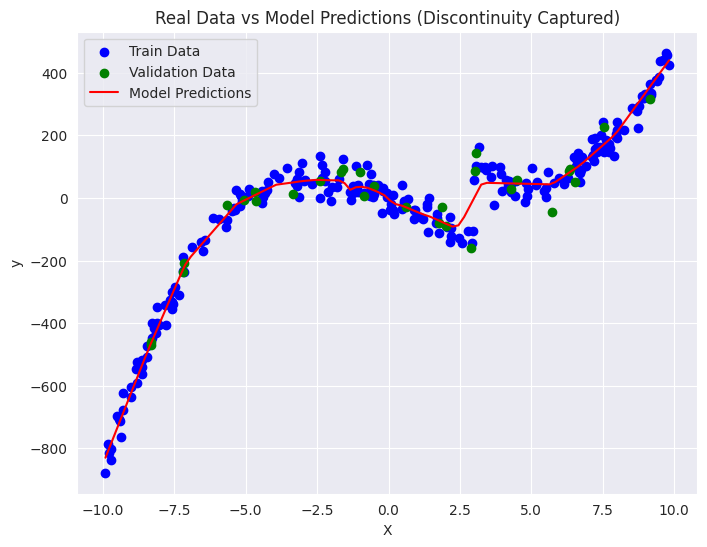

In [50]:
# Plot after training
with torch.no_grad():
    model2.eval()
    y_pred = model2(X_pred.unsqueeze(1)).squeeze()  # Predictions over the full range
    plt.figure(figsize=(8, 6))
    plt.scatter(train_x, train_y, color='blue', label='Train Data')
    plt.scatter(val_x, val_y, color='green', label='Validation Data')
    plt.plot(X_pred, y_pred, color='red', label='Model Predictions')
    plt.title('Real Data vs Model Predictions (Discontinuity Captured)')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()